# **ML модели для оценки недвижимости в Санкт-Петербурге**

**Задача проекта**

На основе имеющейся базы данных по квартирам в Санкт-Петербурге и близлежащих населенных пунктах создать ML модели для оценки стоимости объектов жилой недвижимости. Использовать несколько алгоритмов и оценить их работоспособность.

**Описание данных**

Датасет содержит следующую информацию:
+ total_images - кол-во фотографий по объекту недвижимости в базе
+ last_price - актуальная цена
+ total_area - общая площадь 
+ first_day_exposition - день публикации объявления
+ rooms - кол-во комнат
+ ceiling_height - высота потолков
+ floors_total - всего этажей в доме
+ living_area - жилая площадь
+ floor - этаж
+ is_apartment - является ли объект апартаментом
+ studio - является ли объект студией
+ open_plan - открытая планировка или  нет
+ kitchen_area - площадь кухни
+ balcony - кол-во балконов
+ locality_name - название населенного пункта
+ cityCenters_nearest - расстояние до центра нас.пункта (в м)
+ parks_around3000 - число парков в пределах 3 км
+ parks_nearest - расстояние до ближайшего парка (в м)
+ ponds_around3000 - число водоемов в пределах 3 км
+ ponds_nearest - расстояние до ближайшего водоема (в м)
+ days_exposition - кол-во дней, прошедших с момента публикации объявления


In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

In [157]:
import warnings
warnings.filterwarnings("ignore")

In [158]:
sns.set()

In [159]:
df = pd.read_csv('C:/Rabota/IT/Datasets/real_estate_data.csv', sep='\t')

In [160]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [161]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [162]:
df['exposition_year'] = df['first_day_exposition'].dt.year

In [163]:
def df_eda(df):
  class color:
    BLUE = '\033[94m'
    BOLD = '\033[1m'
    END = '\033[0m'
  
  def tbl_dict_base(df, col):
    tbl_dict = {}
    tbl_dict['valid'] = (~df[col].isnull()).sum()
    tbl_dict['valid_pct'] = tbl_dict['valid']/len(df)
    tbl_dict['missing'] = (df[col].isnull()).sum()
    tbl_dict['missing_pct'] = tbl_dict['missing']/len(df)
    tbl_dict['unique_values'] = df[col].nunique()
    return tbl_dict

  def display_table(tbl_dict, subset1=['missing', 'missing_pct'], \
                    subset2=['valid_pct', 'missing_pct']):
    tbl_det = pd.DataFrame([tbl_dict])
    tbl_det = (
        tbl_det.style.applymap(lambda x: 'color:red' if x > 0 else 'color:green', 
                              subset=subset1)
        .format('{:0.2%}', subset=subset2).hide(axis='index') 
      )
    display(tbl_det)

  pd.set_option('display.max_columns', None)
  print(color.BOLD + 'General information' + color.END)
#   display(df.head())
#   print('')
  display(df.info())
  df_duples = df.copy()
  print('')

  print(color.BOLD + 'Heatmap - missing values' + color.END)
  fig, ax = plt.subplots(figsize=(8,5))
  sns.heatmap(df.isna(), cmap='Blues', cbar=False)
  plt.show();
  print('')
  print('')
  print(color.BOLD + 'Column stats' + color.END)
  print('')

  for col in df.columns:
    if df[col].dtype == 'object':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      try:
        df[col] = df[col].str.replace('ё','е')
        tbl_dict['case_sensitive_dupl'] = (
          df[col].str.lower().duplicated().sum() - df[col].duplicated().sum()
        )
        if tbl_dict['case_sensitive_dupl'] > 0:
          df_duples[col] = df_duples[col].str.lower()
        
        display_table(tbl_dict, ['missing', 'missing_pct', 'case_sensitive_dupl'])
      
      except:
        print('Dtype check needed')
        display_table(tbl_dict)
            
      if tbl_dict['unique_values'] > 5:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', col]
        most_common['Most common'] = (
            most_common['Most common']
            .where(most_common['Most common']
                  .isin(df[col].value_counts(normalize=True).head(5).index), 'other')
        )
        most_common = (
            most_common.groupby('Most common', sort=False)[col]
            .agg('sum').to_frame('')
        )

      else:
        most_common = df[col].value_counts(normalize=True).reset_index()
        most_common.columns=['Most common', '']
        most_common = most_common.set_index('Most common')
      
      display(most_common.style.format('{:0.1%}'))
      print('')

    elif df[col].dtype == 'float' or df[col].dtype == 'int64':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      tbl_dict['zeros'] = len(df[df[col] == 0])
      tbl_dict['negatives'] = len(df[df[col] < 0])
      display_table(tbl_dict)

      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.show();
      tbl_stats = pd.DataFrame({'':[df[col].mean(), df[col].median(), 
                                   df[col].std(), df[col].min(),
                                   df[col].max(), df[col].quantile(0.01),
                                   df[col].quantile(0.99)]})
      tbl_stats.index = ['mean', 'median', 'std', 'min', 'max', 
                         '1st quantile', '99th quantile']
      display(tbl_stats.style.format('{:.2f}'))
      # display(df[col].describe().to_frame('')[1:].style.format("{:.2f}"))
      print('')
      if col.lower() == 'id' or col.lower() == 'userid' or col.lower() == 'user_id':
        id_duples = df[col].duplicated().sum()

    elif df[col].dtype == 'datetime64[ns]':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)

      if tbl_dict['unique_values'] < 50:
        sns.histplot(df[col], bins=tbl_dict['unique_values'])
      elif tbl_dict['unique_values'] > 100:
        sns.histplot(df[col], bins=50)
      else:
        sns.histplot(df[col], bins=tbl_dict['unique_values']//2)
      plt.xticks(rotation=45)
      plt.show();
      display(df[col].apply(['min', 'max', 'mean']).to_frame(''))
      print('')

    elif df[col].dtype == 'bool':
      print(color.BLUE + f'{col} - dtype: {df[col].dtype}' + color.END)
      tbl_dict = tbl_dict_base(df, col)
      display_table(tbl_dict)
      display(df[col].value_counts(normalize=True).to_frame('').style.format('{:0.1%}'))
    
    else:
      print(color.BLUE + col + color.END)
      print('check format')

  id_duples = 0
  if col.lower() == 'id' or col.lower() == 'userid' or col.lower() == 'user_id':
        id_duples = df[col].duplicated().sum()
  print(color.BOLD + 'Duplicates in dataset: ' + color.END)
  tbl_dupl = (
      pd.DataFrame({'duples_cnt':[df.duplicated().sum()], 
                    'duples_pct':[df.duplicated().sum()/len(df)],
                    'case_sensitive_duples':[(df_duples.duplicated().sum()-df.duplicated().sum())],
                    'case_sensitive_pct':[(df_duples.duplicated().sum()-df.duplicated().sum())/len(df)], 
                    'id_duples':[id_duples],
                    'id_duples_pct':[id_duples/len(df)]})
      .style.applymap(lambda x: 'color:red' if x > 0 else 'color:green')
      .format('{:.2%}', subset=['duples_pct', 'case_sensitive_pct', 'id_duples_pct'])
  )
  display(tbl_dupl)

General information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 

None


Heatmap - missing values


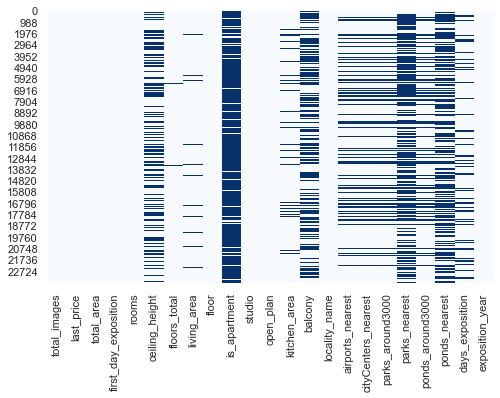



Column stats

total_images - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,38,1059,0


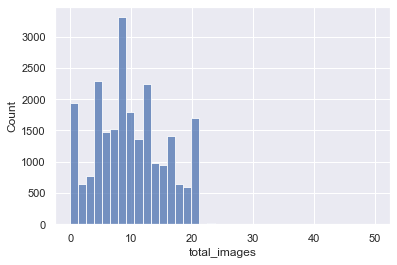

,
mean,9.86
median,9.00
std,5.68
min,0.00
max,50.00
1st quantile,0.00
99th quantile,20.00



last_price - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,2978,0,0


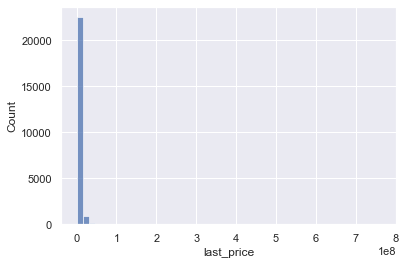

,
mean,6541548.77
median,4650000.00
std,10887013.27
min,12190.00
max,763000000.00
1st quantile,1000000.00
99th quantile,36000000.00



total_area - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,2182,0,0


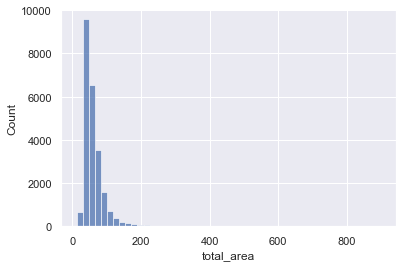

,
mean,60.35
median,52.00
std,35.65
min,12.00
max,900.00
1st quantile,25.20
99th quantile,197.21



first_day_exposition - dtype: datetime64[ns]


valid,valid_pct,missing,missing_pct,unique_values
23699,100.00%,0,0.00%,1491


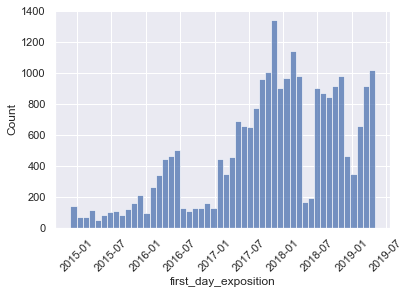

,
min,2014-11-27 00:00:00.000000000
max,2019-05-03 00:00:00.000000000
mean,2017-11-08 21:55:18.975484160



rooms - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,17,197,0


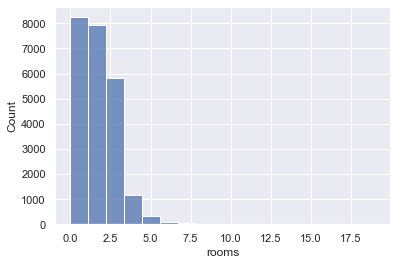

,
mean,2.07
median,2.00
std,1.08
min,0.00
max,19.00
1st quantile,1.00
99th quantile,5.00



ceiling_height - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
14504,61.20%,9195,38.80%,183,0,0


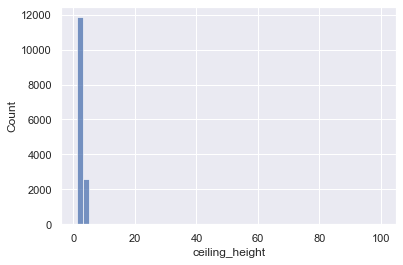

,
mean,2.77
median,2.65
std,1.26
min,1.00
max,100.00
1st quantile,2.50
99th quantile,3.83



floors_total - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23613,99.64%,86,0.36%,36,0,0


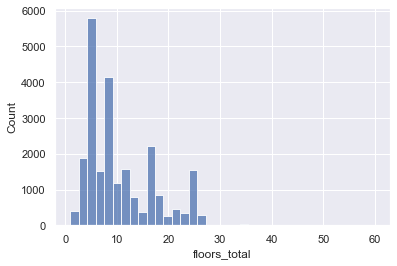

,
mean,10.67
median,9.00
std,6.60
min,1.00
max,60.00
1st quantile,2.00
99th quantile,26.00



living_area - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
21796,91.97%,1903,8.03%,1782,0,0


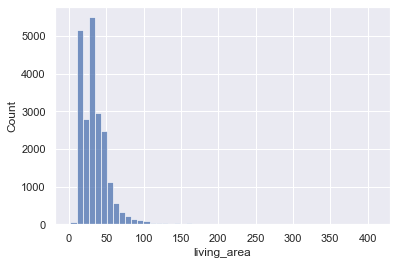

,
mean,34.46
median,30.00
std,22.03
min,2.00
max,409.70
1st quantile,13.00
99th quantile,120.00



floor - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,33,0,0


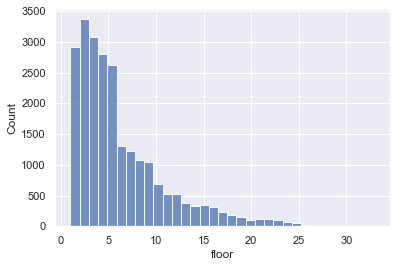

,
mean,5.89
median,4.00
std,4.89
min,1.00
max,33.00
1st quantile,1.00
99th quantile,23.00



is_apartment - dtype: object
Dtype check needed


valid,valid_pct,missing,missing_pct,unique_values
2775,11.71%,20924,88.29%,2


,
Most common,
False,98.2%
True,1.8%



studio - dtype: bool


valid,valid_pct,missing,missing_pct,unique_values
23699,100.00%,0,0.00%,2


,
False,99.4%
True,0.6%


open_plan - dtype: bool


valid,valid_pct,missing,missing_pct,unique_values
23699,100.00%,0,0.00%,2


,
False,99.7%
True,0.3%


kitchen_area - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
21421,90.39%,2278,9.61%,971,0,0


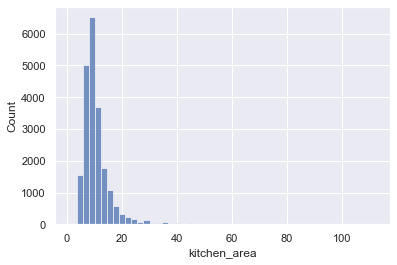

,
mean,10.57
median,9.10
std,5.91
min,1.30
max,112.00
1st quantile,5.00
99th quantile,35.09



balcony - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
12180,51.39%,11519,48.61%,6,3758,0


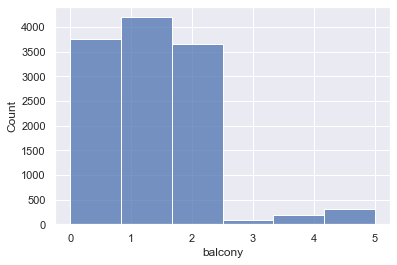

,
mean,1.15
median,1.00
std,1.07
min,0.00
max,5.00
1st quantile,0.00
99th quantile,5.00



locality_name - dtype: object


valid,valid_pct,missing,missing_pct,unique_values,case_sensitive_dupl
23650,99.79%,49,0.21%,364,0


,
Most common,
Санкт-Петербург,66.5%
поселок Мурино,2.4%
поселок Шушары,1.9%
Всеволожск,1.7%
Пушкин,1.6%
other,26.1%



airports_nearest - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
18157,76.62%,5542,23.38%,8275,1,0


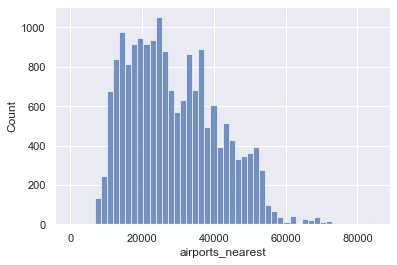

,
mean,28793.67
median,26726.00
std,12630.88
min,0.00
max,84869.00
1st quantile,9412.56
99th quantile,58544.12



cityCenters_nearest - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
18180,76.71%,5519,23.29%,7642,0,0


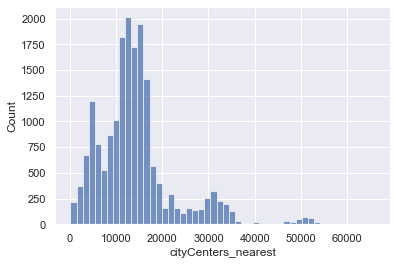

,
mean,14191.28
median,13098.50
std,8608.39
min,181.00
max,65968.00
1st quantile,1326.58
99th quantile,50064.63



parks_around3000 - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
18181,76.72%,5518,23.28%,4,10106,0


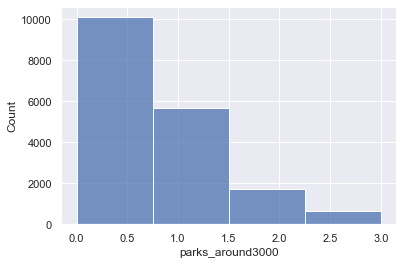

,
mean,0.61
median,0.00
std,0.80
min,0.00
max,3.00
1st quantile,0.00
99th quantile,3.00



parks_nearest - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
8079,34.09%,15620,65.91%,995,0,0


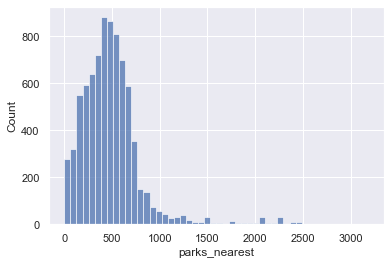

,
mean,490.80
median,455.00
std,342.32
min,1.00
max,3190.00
1st quantile,24.00
99th quantile,2102.00



ponds_around3000 - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
18181,76.72%,5518,23.28%,4,9071,0


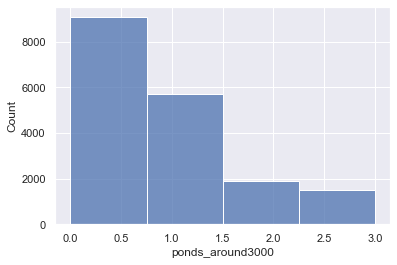

,
mean,0.77
median,1.00
std,0.94
min,0.00
max,3.00
1st quantile,0.00
99th quantile,3.00



ponds_nearest - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
9110,38.44%,14589,61.56%,1096,0,0


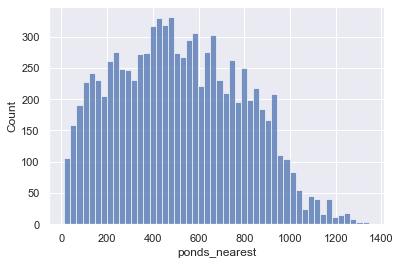

,
mean,517.98
median,502.00
std,277.72
min,13.00
max,1344.00
1st quantile,35.09
99th quantile,1159.00



days_exposition - dtype: float64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
20518,86.58%,3181,13.42%,1141,0,0


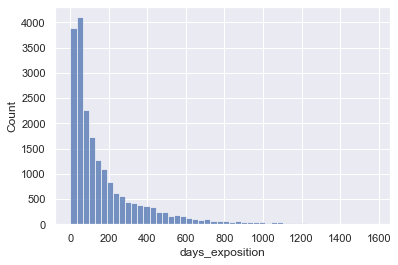

,
mean,180.89
median,95.00
std,219.73
min,1.00
max,1580.00
1st quantile,4.00
99th quantile,1068.66



exposition_year - dtype: int64


valid,valid_pct,missing,missing_pct,unique_values,zeros,negatives
23699,100.00%,0,0.00%,6,0,0


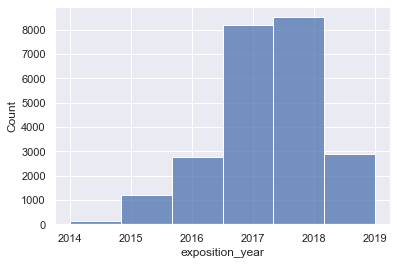

,
mean,2017.37
median,2017.00
std,1.04
min,2014.00
max,2019.00
1st quantile,2015.00
99th quantile,2019.00



Duplicates in dataset: 


,duples_cnt,duples_pct,case_sensitive_duples,case_sensitive_pct,id_duples,id_duples_pct
0,0,0.00%,0,0.00%,0,0.00%


In [164]:
df_eda(df)

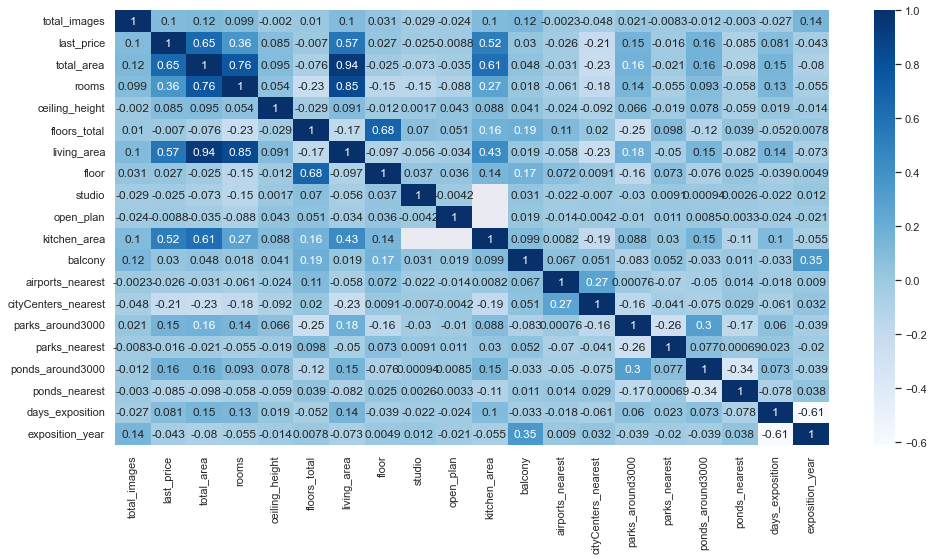

In [165]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(cm, annot=True, cmap='Blues') 
plt.show();

In [166]:
df.locality_name.unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

Заменим в названиях населенных пунктов букву ё на е, заменим дублирующие наименования, а также заменим пропущенные значения, которых у нас 0,21% на no_info. 

In [167]:
df['locality_name'] = df['locality_name'].str.replace('ё','е')

In [168]:
df['locality_name'] = (df['locality_name'].str.replace('поселок при железнодорожной станции Вещево', 'поселок станции Вещево')
    .replace('поселок при железнодорожной станции Приветнинское', 'поселок станции Приветнинское')
    .replace('поселок Рябово', 'поселок городского типа Рябово')
    .replace('деревня Кудрово', 'Кудрово'))

In [169]:
df.locality_name = df.locality_name.fillna('no_info')

In [170]:
df.query('ceiling_height > 6').ceiling_height.unique()

array([ 25. ,  32. ,   8. ,  27. ,  24. ,  26. ,   8.3,  14. ,  20. ,
        22.6,  27.5,  10.3, 100. ])

В столбце ceiling_height (высота потолков) присутствуют аномальные значения (напр., высота потолков 20 м и даже 100 м или, наоборот, нерально низкие потолки - 1 м). Заменим эти аномальные значения на медианное значение высоты потолков для соответствующей площади квартиры.

Кроме того, нереальные значения присутствуют в столбце floors_total: дома с этажностью более 37 этажей (37-этажное здание - самое высокое жилое здание Санкт-Петербурга).

In [171]:
df['area_grouped'] = pd.cut(df['total_area'], [0, 35, 65, 110, float('inf')])
df.groupby('area_grouped')['ceiling_height'].agg(['count', 'mean', 'median'])

,count,mean,median
area_grouped,,,
"(0.0, 35.0]",2053,2.689289,2.55
"(35.0, 65.0]",7914,2.703369,2.60
"(65.0, 110.0]",3600,2.873400,2.75
"(110.0, inf]",937,3.135550,3.00


In [172]:
df['ceiling_height'] = (
    df['ceiling_height'].where((df.ceiling_height < 6)&(df.ceiling_height > 2.4), 
                               df.groupby('area_grouped')['ceiling_height'].median())
)

In [173]:
df['ceiling_height'] = (
    df['ceiling_height']
    .fillna(df.groupby('area_grouped')['ceiling_height']
            .transform('median'))
)

In [174]:
def floors_total_clean(x):
    if x > 37:
        return np.nan
    return x

In [175]:
df['floors_total'] = df['floors_total'].apply(floors_total_clean)

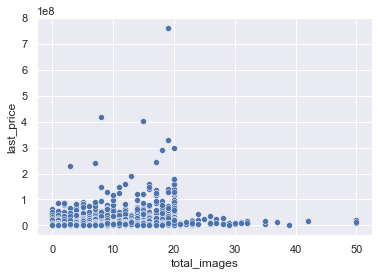

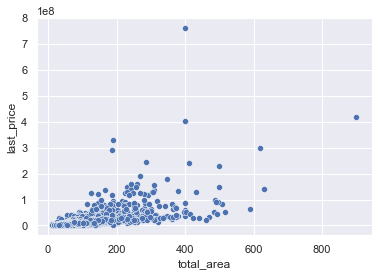

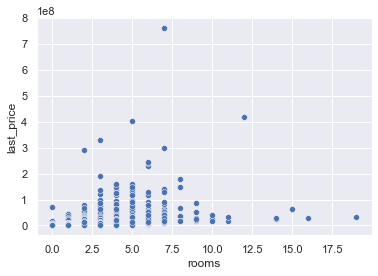

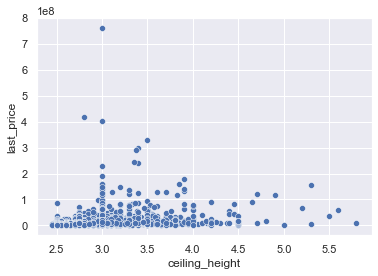

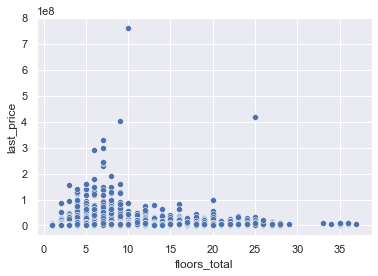

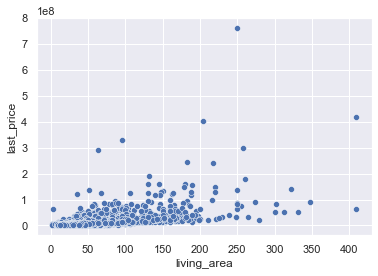

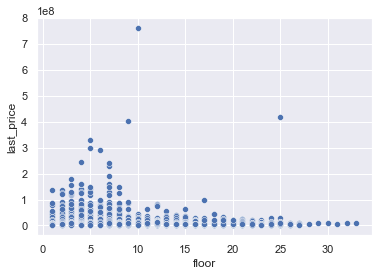

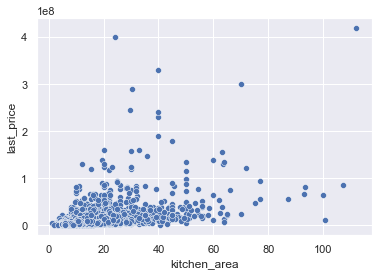

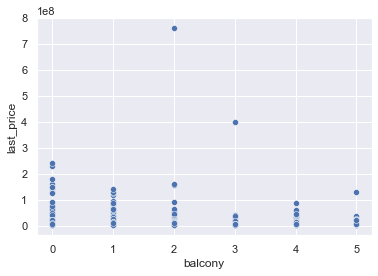

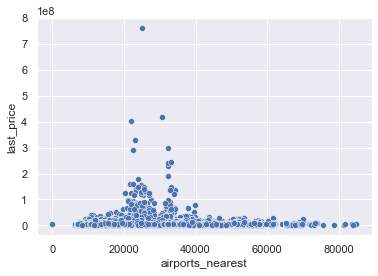

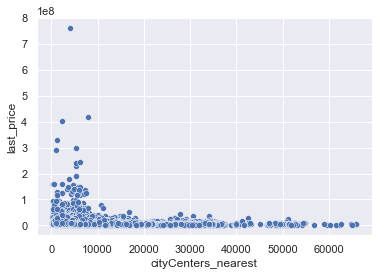

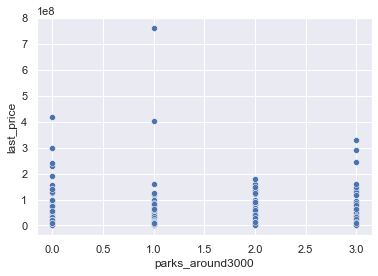

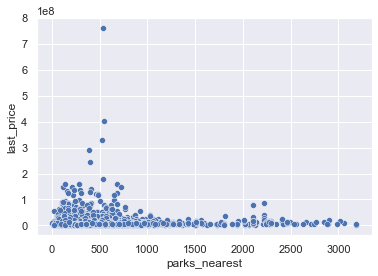

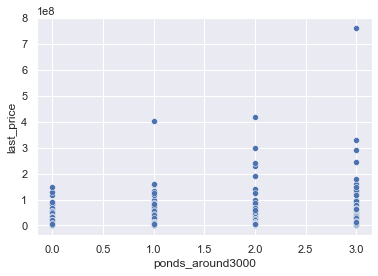

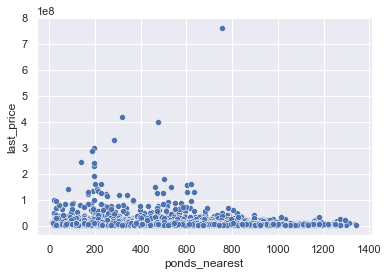

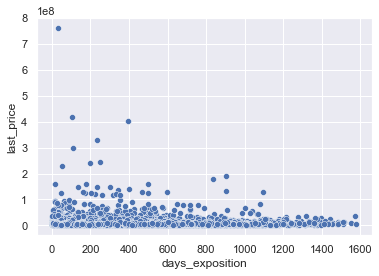

In [176]:
for col in df[['total_images', 'total_area',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'kitchen_area', 'balcony',
       'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']].columns:
    sns.scatterplot(x=df[col], y=df['last_price']) 
    plt.show();

### **Модель 1 - CatBoostRegressor**

In [25]:
! pip install catboost

In [26]:
from catboost import CatBoostRegressor

In [11]:
def calculate_metrics(y_pred):
  print('MAE: ', mean_absolute_error(test.last_price, test[y_pred]))
  print('MAPE: ', mean_absolute_percentage_error(test.last_price, test[y_pred]))
  print('R2: ', r2_score(test.last_price, test[y_pred]))

In [177]:
train, test = train_test_split(df, train_size=0.6, random_state=42)
val, test = train_test_split(test, train_size=0.5, random_state=42)

In [178]:
train.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'exposition_year', 'area_grouped'],
      dtype='object')

Целевая переменная - last_price. В качестве признаков используем столбцы total_images, total_area, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area, cityCenters_nearest, parks_around3000, ponds_around3000, категориальную переменную locality_name, а также exposition_year (выделенный год из даты публикации объявления). 

Столбцы is_apartment, open_space и studio использовать не представляется целесообразным либо из-за большого числа пропусков (is_apartment), либо из-за однородности данных (studio, open_space - в обоих столбцах подавляющее число значений False). 

In [179]:
X = ['total_images', 'total_area', 'rooms', 
     'ceiling_height', 'floors_total', 'living_area', 
     'floor', 'kitchen_area', 'balcony', 
     'cityCenters_nearest', 'parks_around3000', 
     'ponds_around3000', 'parks_nearest', 'ponds_nearest', 
     'locality_name', 'exposition_year']

cat_features = ['locality_name']
y = ['last_price']

In [180]:
parametres = {'cat_features':cat_features,
              'eval_metric':'MAPE',
              'random_seed':42,
              # 'learning_rate': 0.08,
              'verbose':100}

In [181]:
model = CatBoostRegressor(**parametres)

In [182]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

Learning rate set to 0.07725
0:	learn: 0.8100506	test: 0.7566600	best: 0.7566600 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.3032356	test: 0.2205004	best: 0.2205004 (100)	total: 1.86s	remaining: 16.6s
200:	learn: 0.2626013	test: 0.1924682	best: 0.1924682 (200)	total: 3.54s	remaining: 14.1s
300:	learn: 0.2458583	test: 0.1845558	best: 0.1845558 (300)	total: 5.3s	remaining: 12.3s
400:	learn: 0.2269206	test: 0.1801180	best: 0.1801180 (400)	total: 7.14s	remaining: 10.7s
500:	learn: 0.2126186	test: 0.1782307	best: 0.1782307 (500)	total: 9.04s	remaining: 9.01s
600:	learn: 0.1962634	test: 0.1769472	best: 0.1769472 (600)	total: 10.8s	remaining: 7.16s
700:	learn: 0.1840973	test: 0.1756564	best: 0.1756564 (700)	total: 12.5s	remaining: 5.31s
800:	learn: 0.1762978	test: 0.1748611	best: 0.1748611 (800)	total: 14.2s	remaining: 3.53s
900:	learn: 0.1692197	test: 0.1738416	best: 0.1738416 (900)	total: 16s	remaining: 1.76s
999:	learn: 0.1626976	test: 0.1729445	best: 0.1729412 (998)	total: 17.9s	rema

In [183]:
test['price_pred'] = model.predict(test[X])

In [184]:
calculate_metrics('price_pred')

MAE:  1444969.5842345718
MAPE:  0.17333349636507067
R2:  0.47205293543732196


In [185]:
mape_dict = {}
r2_dict = {}

In [186]:
mape_dict['CatBoost'] =  mean_absolute_percentage_error(test.last_price, test['price_pred'])
r2_dict['CatBoost'] = r2_score(test.last_price, test['price_pred'])

In [187]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_area,34.349267
1,floors_total,10.413663
2,living_area,9.120339
3,kitchen_area,8.602753
4,cityCenters_nearest,7.772626
5,ponds_around3000,4.330407
6,ponds_nearest,4.238137
7,parks_around3000,3.796995
8,total_images,3.789566
9,ceiling_height,3.371069


In [188]:
test['error'] = test['price_pred'] - test['last_price']
test['error_abs'] = abs(test['error'])

In [189]:
# Зададим функцию для расчета разницы между MAE для всего датасета и MAE, рассчитанному для отдельных групп
def display_error(col):
    t = test.groupby(col)[['error_abs', 'error']].agg(['count', 'mean'])
    t.columns = ['_'.join(col).strip() for col in t.columns.values]
    t['mae'] = test['error_abs'].mean()
    t = t.drop('error_count', axis=1)
    t['mean_error_diff'] = t['error_abs_mean'] - t['mae']
    display(t.style.format("{:.1f}").background_gradient(cmap='Reds', subset = 'mean_error_diff'))

In [190]:
display_error('rooms')

,error_abs_count,error_abs_mean,error_mean,mae,mean_error_diff
rooms,,,,,
0,28.0,545152.2,84645.5,1444969.6,-899817.4
1,1595.0,514380.3,57613.4,1444969.6,-930589.3
2,1605.0,885847.0,95420.3,1444969.6,-559122.6
3,1186.0,1555284.0,-95327.0,1444969.6,110314.4
4,223.0,3256511.3,278509.9,1444969.6,1811541.7
5,65.0,8422962.8,870714.4,1444969.6,6977993.2
6,24.0,28027669.4,-2028592.7,1444969.6,26582699.8
7,7.0,106014545.3,-75035265.4,1444969.6,104569575.7
8,2.0,3913854.0,-1624517.0,1444969.6,2468884.4


In [191]:
test['area_groups2'] = pd.cut(test['total_area'], [0, 40, 65, 80, 100, 120, float('inf')])

In [192]:
display_error('area_groups2')

,error_abs_count,error_abs_mean,error_mean,mae,mean_error_diff
area_groups2,,,,,
"(0.0, 40.0]",1184.0,409034.1,51716.5,1444969.6,-1035935.5
"(40.0, 65.0]",2167.0,617379.1,38609.1,1444969.6,-827590.5
"(65.0, 80.0]",642.0,1182227.7,-1058.1,1444969.6,-262741.9
"(80.0, 100.0]",407.0,2053653.7,-36343.5,1444969.6,608684.1
"(100.0, 120.0]",142.0,3621918.2,-157886.2,1444969.6,2176948.6
"(120.0, inf]",198.0,14736663.8,-2037420.1,1444969.6,13291694.2


In [193]:
test['floors_total_groups'] = pd.qcut(test['floors_total'], 5)

In [194]:
display_error('floors_total_groups')

,error_abs_count,error_abs_mean,error_mean,mae,mean_error_diff
floors_total_groups,,,,,
"(0.999, 5.0]",1601.0,1339364.7,30238.9,1444969.6,-105604.9
"(5.0, 7.0]",305.0,4296282.5,-24588.3,1444969.6,2851312.9
"(7.0, 10.0]",1073.0,1613945.2,-401241.9,1444969.6,168975.6
"(10.0, 16.0]",843.0,998104.1,-30381.1,1444969.6,-446865.5
"(16.0, 37.0]",897.0,882317.2,137730.5,1444969.6,-562652.4


In [195]:
test.query('floors_total == 6').sort_values(by=['error_abs'], ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,exposition_year,area_grouped,price_pred,error,error_abs,area_groups2,floors_total_groups
22229,16,148000000.0,256.0,2016-03-16,5,3.00,6.0,179.0,5,NaN,False,False,36.0,0.0,Санкт-Петербург,24072.0,3639.0,2.0,727.0,3.0,462.0,233.0,2016,"(110.0, inf]",6.516393e+07,-8.283607e+07,8.283607e+07,"(120.0, inf]","(5.0, 7.0]"
16647,15,122000000.0,145.0,2017-04-25,3,3.30,6.0,36.0,2,NaN,False,False,72.0,NaN,Санкт-Петербург,33931.0,7023.0,2.0,478.0,3.0,250.0,335.0,2017,"(110.0, inf]",4.764112e+07,-7.435888e+07,7.435888e+07,"(120.0, inf]","(5.0, 7.0]"
22038,10,11940000.0,206.0,2018-12-12,5,3.50,6.0,160.0,3,NaN,False,False,26.0,NaN,Санкт-Петербург,20123.0,1852.0,3.0,510.0,3.0,417.0,90.0,2018,"(110.0, inf]",5.918719e+07,4.724719e+07,4.724719e+07,"(120.0, inf]","(5.0, 7.0]"
16091,20,11999000.0,167.0,2016-06-23,5,3.20,6.0,106.0,2,False,False,False,30.0,0.0,Санкт-Петербург,20079.0,2357.0,2.0,287.0,3.0,38.0,76.0,2016,"(110.0, inf]",4.179024e+07,2.979124e+07,2.979124e+07,"(120.0, inf]","(5.0, 7.0]"
21338,15,3200000.0,190.0,2016-06-16,1,3.00,6.0,43.0,4,False,False,False,13.0,0.0,Санкт-Петербург,22592.0,4312.0,1.0,350.0,0.0,NaN,11.0,2016,"(110.0, inf]",2.430690e+07,2.110690e+07,2.110690e+07,"(120.0, inf]","(5.0, 7.0]"
8608,13,15600000.0,126.2,2017-10-13,3,3.24,6.0,47.8,5,NaN,False,False,41.3,NaN,Санкт-Петербург,37288.0,8205.0,1.0,1951.0,3.0,257.0,156.0,2017,"(110.0, inf]",3.627799e+07,2.067799e+07,2.067799e+07,"(120.0, inf]","(5.0, 7.0]"
5297,19,45000000.0,96.0,2018-11-15,2,3.20,6.0,NaN,4,True,False,False,45.0,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,NaN,2018,"(65.0, 110.0]",2.541793e+07,-1.958207e+07,1.958207e+07,"(80.0, 100.0]","(5.0, 7.0]"
18320,13,35500000.0,188.0,2017-12-13,5,3.55,6.0,NaN,5,NaN,False,False,NaN,NaN,Санкт-Петербург,22526.0,3175.0,1.0,1028.0,1.0,399.0,90.0,2017,"(110.0, inf]",1.856572e+07,-1.693428e+07,1.693428e+07,"(120.0, inf]","(5.0, 7.0]"
18882,19,11990000.0,146.0,2019-02-27,4,3.00,6.0,77.6,5,NaN,False,False,27.2,NaN,Санкт-Петербург,25761.0,5671.0,2.0,375.0,1.0,479.0,NaN,2019,"(110.0, inf]",2.805820e+07,1.606820e+07,1.606820e+07,"(120.0, inf]","(5.0, 7.0]"
11961,2,11270000.0,123.0,2019-04-26,4,3.00,6.0,NaN,2,NaN,False,False,NaN,NaN,Санкт-Петербург,26318.0,5021.0,3.0,590.0,0.0,NaN,5.0,2019,"(110.0, inf]",2.397054e+07,1.270054e+07,1.270054e+07,"(120.0, inf]","(5.0, 7.0]"


In [196]:
test['cityCenters_nearest_groups'] = pd.qcut(test['cityCenters_nearest'], 5)

In [197]:
display_error('cityCenters_nearest_groups')

,error_abs_count,error_abs_mean,error_mean,mae,mean_error_diff
cityCenters_nearest_groups,,,,,
"(207.999, 7946.6]",727.0,5151395.7,-690448.6,1444969.6,3706426.1
"(7946.6, 11790.2]",727.0,1078191.7,253184.3,1444969.6,-366777.9
"(11790.2, 14163.4]",727.0,806554.8,-41245.2,1444969.6,-638414.8
"(14163.4, 17121.0]",732.0,753330.1,61219.5,1444969.6,-691639.5
"(17121.0, 65105.0]",722.0,702425.2,56821.2,1444969.6,-742544.4


In [198]:
test.query('cityCenters_nearest < 7000').sort_values(by=['error_abs'], ascending=False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,exposition_year,area_grouped,price_pred,error,error_abs,area_groups2,floors_total_groups,cityCenters_nearest_groups
12971,19,763000000.0,400.0,2017-09-30,7,3.00,10.0,250.0,10,NaN,False,False,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,2017,"(110.0, inf]",1.362280e+08,-6.267720e+08,6.267720e+08,"(120.0, inf]","(7.0, 10.0]","(207.999, 7946.6]"
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7.0,182.8,4,NaN,False,False,29.8,NaN,Санкт-Петербург,33143.0,6235.0,3.0,400.0,3.0,140.0,249.0,2017,"(110.0, inf]",8.366466e+07,-1.613353e+08,1.613353e+08,"(120.0, inf]","(5.0, 7.0]","(207.999, 7946.6]"
14088,8,51000000.0,402.0,2017-02-07,6,3.15,8.0,300.0,6,NaN,False,False,56.0,2.0,Санкт-Петербург,24484.0,5052.0,1.0,253.0,0.0,NaN,32.0,2017,"(110.0, inf]",1.851406e+08,1.341406e+08,1.341406e+08,"(120.0, inf]","(7.0, 10.0]","(207.999, 7946.6]"
22229,16,148000000.0,256.0,2016-03-16,5,3.00,6.0,179.0,5,NaN,False,False,36.0,0.0,Санкт-Петербург,24072.0,3639.0,2.0,727.0,3.0,462.0,233.0,2016,"(110.0, inf]",6.516393e+07,-8.283607e+07,8.283607e+07,"(120.0, inf]","(5.0, 7.0]","(207.999, 7946.6]"
5893,3,230000000.0,500.0,2017-05-31,6,3.00,7.0,NaN,7,NaN,False,False,40.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0,2017,"(110.0, inf]",1.483535e+08,-8.164649e+07,8.164649e+07,"(120.0, inf]","(5.0, 7.0]","(207.999, 7946.6]"
509,5,90000000.0,225.0,2016-06-26,6,3.00,4.0,134.0,2,NaN,False,False,19.5,2.0,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0,2016,"(110.0, inf]",1.913258e+07,-7.086742e+07,7.086742e+07,"(120.0, inf]","(0.999, 5.0]","(207.999, 7946.6]"
6462,2,82000000.0,114.0,2015-12-17,3,3.00,5.0,78.5,4,NaN,False,False,20.0,0.0,Санкт-Петербург,22460.0,3400.0,2.0,218.0,3.0,69.0,651.0,2015,"(110.0, inf]",1.449904e+07,-6.750096e+07,6.750096e+07,"(100.0, 120.0]","(0.999, 5.0]","(207.999, 7946.6]"
1085,16,75000000.0,323.0,2017-07-10,5,4.00,5.0,255.7,4,NaN,False,False,66.0,NaN,Санкт-Петербург,23713.0,594.0,3.0,398.0,2.0,515.0,259.0,2017,"(110.0, inf]",1.240302e+08,4.903021e+07,4.903021e+07,"(120.0, inf]","(0.999, 5.0]","(207.999, 7946.6]"
22038,10,11940000.0,206.0,2018-12-12,5,3.50,6.0,160.0,3,NaN,False,False,26.0,NaN,Санкт-Петербург,20123.0,1852.0,3.0,510.0,3.0,417.0,90.0,2018,"(110.0, inf]",5.918719e+07,4.724719e+07,4.724719e+07,"(120.0, inf]","(5.0, 7.0]","(207.999, 7946.6]"
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9.0,131.0,7,NaN,False,False,20.0,0.0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,501.0,2015,"(110.0, inf]",1.129425e+08,-4.704153e+07,4.704153e+07,"(120.0, inf]","(7.0, 10.0]","(207.999, 7946.6]"


Мы видим, что самые большие ошибки модель делает применительно к большим по российским меркам квартирам: шесть и более комнат, метраж более 100 м. В том числе, речь идет о больших квартирах в многоквартирных домах высотой 6-7 этажей, а также квартирах, расположенных ближе всего к центру Санкт-Петербурга. 

Ошибки модели на подобных квартирах вполне объяснимы и предсказуемы: такая недвижимость выходит за рамки стандартной и в ее ценообразовании играют роль, как правило, факторы, которые не отражены в нашей матрице признаков (напр., наличие дизайнерского ремонта, дорогой мебели и т.д.). В отсутствии соответствующих данных оценить квартиру в элитном сегменте представляется крайне затруднительно и неизбежно будет сопровождаться существенными ошибками. 

Посмотрим, насколько изменится прогнозная ценность модели, если мы ограничим массив стандартными квартирами площадью, к примеру, не более 100 кв.м.

### **Модель CatBoostRegressor для квартир площадью не более 100 кв.м**

In [199]:
df_small = df.query('total_area <= 100').copy()

In [200]:
train, test = train_test_split(df_small, train_size=0.6, random_state=42)
val, test = train_test_split(test, train_size=0.5, random_state=42)

In [201]:
X = ['total_images', 'total_area', 'rooms', 
     'ceiling_height', 'floors_total', 'living_area', 
     'floor', 'kitchen_area', 'balcony', 
     'cityCenters_nearest', 'parks_around3000', 
     'ponds_around3000', 'parks_nearest', 'ponds_nearest', 
     'locality_name', 'exposition_year']

cat_features = ['locality_name']
y = ['last_price']

In [202]:
parametres = {'cat_features':cat_features,
              'eval_metric':'MAPE',
              'random_seed':42,
              'learning_rate': 0.08,
              'verbose':100}

In [203]:
model = CatBoostRegressor(**parametres)

In [204]:
model.fit(train[X], train[y], eval_set=(val[X], val[y]))

0:	learn: 0.5217089	test: 0.5172380	best: 0.5172380 (0)	total: 16.7ms	remaining: 16.7s
100:	learn: 0.1670218	test: 0.1682440	best: 0.1682440 (100)	total: 1.69s	remaining: 15s
200:	learn: 0.1562859	test: 0.1612552	best: 0.1612552 (200)	total: 3.56s	remaining: 14.1s
300:	learn: 0.1492437	test: 0.1575383	best: 0.1575383 (300)	total: 5.41s	remaining: 12.6s
400:	learn: 0.1440358	test: 0.1556914	best: 0.1556914 (400)	total: 7.34s	remaining: 11s
500:	learn: 0.1398626	test: 0.1547638	best: 0.1547638 (500)	total: 8.99s	remaining: 8.96s
600:	learn: 0.1367690	test: 0.1538772	best: 0.1538772 (600)	total: 10.6s	remaining: 7.06s
700:	learn: 0.1337374	test: 0.1531401	best: 0.1530918 (697)	total: 12.3s	remaining: 5.25s
800:	learn: 0.1309362	test: 0.1526064	best: 0.1525882 (790)	total: 14.3s	remaining: 3.54s
900:	learn: 0.1283360	test: 0.1524594	best: 0.1523242 (860)	total: 16.1s	remaining: 1.77s
999:	learn: 0.1258699	test: 0.1522194	best: 0.1521825 (988)	total: 17.8s	remaining: 0us

bestTest = 0.15218

In [205]:
test['price_pred'] = model.predict(test[X])

In [206]:
calculate_metrics('price_pred')

MAE:  704046.4727577012
MAPE:  0.14544005298582913
R2:  0.8018281227368653


In [207]:
mape_sm_dict = {}
r2_sm_dict = {}

In [208]:
mape_sm_dict['CatBoost'] =  mean_absolute_percentage_error(test.last_price, test['price_pred'])
r2_sm_dict['CatBoost'] = r2_score(test.last_price, test['price_pred'])

### **Альтернативные модели: Ridge, Lasso, DecisionTree, RandomForest, GradientBoosting**

Применим другие алгоритмы - Ridge, Lasso, DecisionTree, RandomForest, GradientBoosting. Все они требуют дополнительной обработки данных. Кроме того, из-за большого числа названий населенных пунктов признак locality_name мы не сможем использоваться в полной мере, как с моделью CatBoost, поэтому оптимизируем географические данные и оставим в столбце бинарную переменную, обозначающую Санкт-Петербург (1) или другой населенный пункт (0). 

In [209]:
df.groupby('area_grouped')['living_area'].agg(['count', 'mean', 'median'])

,count,mean,median
area_grouped,,,
"(0.0, 35.0]",3257,16.899217,17.0
"(35.0, 65.0]",12166,27.546322,28.3
"(65.0, 110.0]",5138,47.559089,47.0
"(110.0, inf]",1235,94.344494,82.8


In [210]:
df['living_area'] = df['living_area'].fillna(df.groupby('area_grouped')['living_area'].transform('median'))

In [211]:
df.groupby('area_grouped')['kitchen_area'].agg(['count', 'mean', 'median'])

,count,mean,median
area_grouped,,,
"(0.0, 35.0]",2896,7.330214,7.0
"(35.0, 65.0]",12131,9.192756,8.7
"(65.0, 110.0]",5145,12.851887,11.5
"(110.0, inf]",1249,22.055452,18.0


In [212]:
df['kitchen_area'] = df['kitchen_area'].fillna(df.groupby('area_grouped')['kitchen_area'].transform('mean'))

In [213]:
df['floors_total'] = df['floors_total'].fillna(df['floor'])

In [214]:
df.groupby('area_grouped')['rooms'].agg(['count', 'mean', 'median'])

,count,mean,median
area_grouped,,,
"(0.0, 35.0]",3522,0.956559,1.0
"(35.0, 65.0]",13232,1.811895,2.0
"(65.0, 110.0]",5570,2.864811,3.0
"(110.0, inf]",1375,4.197091,4.0


In [215]:
df['rooms'] = df['rooms'].where(df.rooms != 0, df.groupby('area_grouped')['rooms'].transform('mean').astype('int'))

In [216]:
df['parks_around3000'] = df.parks_around3000.fillna(0)
df['ponds_around3000'] = df.ponds_around3000.fillna(0)
df['parks_nearest'] = df.parks_nearest.fillna(0)
df['ponds_nearest'] = df.ponds_nearest.fillna(0)
df['balcony'] = df.balcony.fillna(0)

In [217]:
df['cityCenters_nearest'] = (
    df['cityCenters_nearest']
    .fillna(df.query('locality_name != "Санкт-Петербург"')['cityCenters_nearest']
            .mean())
)

In [218]:
df['is_sp'] = [1 if x == "Санкт-Петербург" else 0 for x in df.locality_name]

In [219]:
df_ml = df[['total_images', 'total_area', 
            'rooms', 'ceiling_height', 'floors_total', 
            'living_area', 'floor', 'kitchen_area', 
            'balcony', 'is_sp', 'cityCenters_nearest', 
            'parks_around3000', 'ponds_around3000', 
            'parks_nearest', 'ponds_nearest', 
            'exposition_year', 'last_price']]

In [220]:
train, test = train_test_split(df_ml, train_size=0.8, random_state=42)

In [221]:
X = ['total_images', 'total_area', 'rooms', 
     'ceiling_height', 'floors_total', 
     'living_area', 'floor', 'kitchen_area', 
     'balcony', 'is_sp', 'cityCenters_nearest', 
     'parks_around3000', 'ponds_around3000', 
     'parks_nearest', 'ponds_nearest', 'exposition_year']

y = ['last_price']

In [222]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(train[X])

StandardScaler()

In [223]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(train[X])
X_test_st = scaler.transform(test[X])

In [224]:
models = [
    Lasso(random_state=42),
    Ridge(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]

In [225]:
model_names = ['Lasso', 'Ridge',
    'DecisionTree', 'RandomForest',
    'GradientBoosting']

In [226]:
def make_prediction(m, X_train, y_train, X_test):
    model = m
    model.fit(X_train_st, train[y])
    test['price_pred'] = model.predict(X_test_st)
    calculate_metrics('price_pred')

In [228]:
class color:
    BLUE = '\033[94m'
    END = '\033[0m'
    
for i in range(len(models)):
    print(color.BLUE + model_names[i] + color.END)
    make_prediction(models[i], X_train_st, train[y].values.ravel(), X_test_st)
    print('')
    mape_dict[model_names[i]] =  mean_absolute_percentage_error(test.last_price, test['price_pred'])
    r2_dict[model_names[i]] = r2_score(test.last_price, test['price_pred'])

Lasso
MAE:  2267145.8620889266
MAPE:  0.36648824745549297
R2:  0.3235940226958135

Ridge
MAE:  2267009.840276891
MAPE:  0.36645474291450064
R2:  0.32358447878713303

DecisionTree
MAE:  1922858.484599156
MAPE:  0.24737857344048494
R2:  0.593558235157837

RandomForest
MAE:  1429859.0275534457
MAPE:  0.1777972858493442
R2:  0.4659094740197943

GradientBoosting
MAE:  1618735.1143632357
MAPE:  0.21647002116368672
R2:  0.4619703015936367



In [229]:
mape_dict

{'CatBoost': 0.17333349636507067,
 'Lasso': 0.36648824745549297,
 'Ridge': 0.36645474291450064,
 'DecisionTree': 0.24737857344048494,
 'RandomForest': 0.1777972858493442,
 'GradientBoosting': 0.21647002116368672}

In [230]:
r2_dict

{'CatBoost': 0.47205293543732196,
 'Lasso': 0.3235940226958135,
 'Ridge': 0.32358447878713303,
 'DecisionTree': 0.593558235157837,
 'RandomForest': 0.4659094740197943,
 'GradientBoosting': 0.4619703015936367}

### **Альтернативные модели для квартир площадью не более 100 кв.м**

In [231]:
df_ml_small = df_ml.query('total_area <= 100').copy()

In [232]:
train, test = train_test_split(df_ml_small, train_size=0.8, random_state=42)

In [233]:
X = ['total_images', 'total_area', 'rooms', 
     'ceiling_height', 'floors_total', 
     'living_area', 'floor', 'kitchen_area', 
     'balcony', 'is_sp', 'cityCenters_nearest', 
     'parks_around3000', 'ponds_around3000', 
     'parks_nearest', 'ponds_nearest', 'exposition_year']

y = ['last_price']

In [234]:
scaler = StandardScaler()
scaler.fit(train[X])

StandardScaler()

In [235]:
X_train_st = scaler.transform(train[X])
X_test_st = scaler.transform(test[X])

In [236]:
for i in range(len(models)):
    print(color.BLUE + model_names[i] + color.END)
    make_prediction(models[i], X_train_st, train[y].values.ravel(), X_test_st)
    print('')
    mape_sm_dict[model_names[i]] =  mean_absolute_percentage_error(test.last_price, test['price_pred'])
    r2_sm_dict[model_names[i]] = r2_score(test.last_price, test['price_pred'])

Lasso
MAE:  1000446.9083815055
MAPE:  0.23298681784826114
R2:  0.6657339097760396

Ridge
MAE:  1000425.568770674
MAPE:  0.232979258165893
R2:  0.6657344293118006

DecisionTree
MAE:  1075550.0660873542
MAPE:  0.22565551200131287
R2:  0.5248444682466379

RandomForest
MAE:  769660.2558541048
MAPE:  0.16401746101720324
R2:  0.7587614848987387

GradientBoosting
MAE:  822106.8416770779
MAPE:  0.17852351134902014
R2:  0.7396543971594483



In [237]:
mape_sm_dict

{'CatBoost': 0.14544005298582913,
 'Lasso': 0.23298681784826114,
 'Ridge': 0.232979258165893,
 'DecisionTree': 0.22565551200131287,
 'RandomForest': 0.16401746101720324,
 'GradientBoosting': 0.17852351134902014}

In [238]:
r2_sm_dict

{'CatBoost': 0.8018281227368653,
 'Lasso': 0.6657339097760396,
 'Ridge': 0.6657344293118006,
 'DecisionTree': 0.5248444682466379,
 'RandomForest': 0.7587614848987387,
 'GradientBoosting': 0.7396543971594483}

### **Оценка моделей с помощью метрик MAPE и R2**

Для оценки моделей были выбраны метрики MAPE и R2, причем в нашем случае предпочтение отдается метрике MAPE как более показательной для оценки прогнозной цены на объекты недвижимости. Нам важно увидеть, какая модель дает меньшую среднюю абсолютную ошибку в процентном отношении от реальной цены квартиры. 

In [239]:
mape = pd.DataFrame([mape_dict])

In [240]:
r2 = pd.DataFrame([r2_dict])

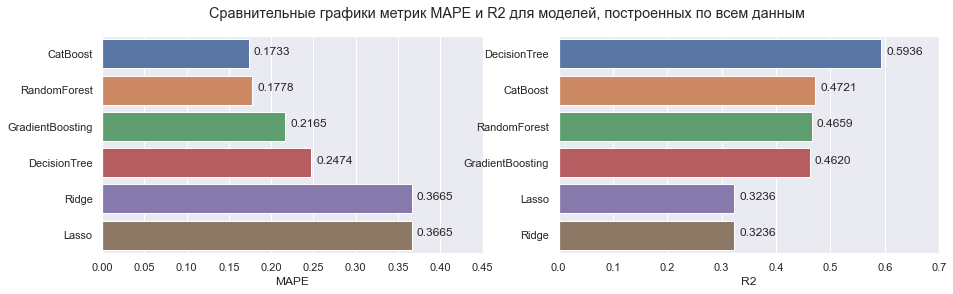

In [241]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(y=mape.T.sort_values(by=0).index, x=mape.T.sort_values(by=0)[0], ax=ax[0])
sns.barplot(y=r2.T.sort_values(by=0, ascending=False).index, x=r2.T.sort_values(by=0, ascending=False)[0], ax=ax[1])
for p in ax[0].patches:
    ax[0].annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.7),
                xytext=(5, 10), textcoords='offset points')

for p in ax[1].patches:
    ax[1].annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.7),
                xytext=(5, 10), textcoords='offset points')
    
# ax[0].set_title('MAPE')
ax[0].set_xlabel('MAPE')
ax[0].set_xlim(0, 0.45)
# ax[1].set_title('R2')
ax[1].set_xlabel('R2')
ax[1].set_xlim(0, 0.7)
plt.suptitle('Сравнительные графики метрик MAPE и R2 для моделей, построенных по всем данным')
plt.show();

In [242]:
mape_sm = pd.DataFrame([mape_sm_dict])
r2_sm = pd.DataFrame([r2_sm_dict])

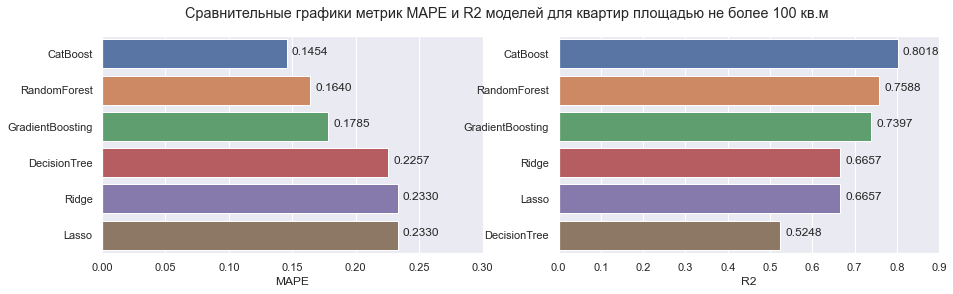

In [243]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(y=mape_sm.T.sort_values(by=0).index, x=mape_sm.T.sort_values(by=0)[0], ax=ax[0])
sns.barplot(y=r2_sm.T.sort_values(by=0, ascending=False).index, x=r2_sm.T.sort_values(by=0, ascending=False)[0], ax=ax[1])
for p in ax[0].patches:
    ax[0].annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.7),
                xytext=(5, 10), textcoords='offset points')

for p in ax[1].patches:
    ax[1].annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.7),
                xytext=(5, 10), textcoords='offset points')
    
ax[0].set_xlabel('MAPE')
ax[0].set_xlim(0, 0.3)
ax[1].set_xlabel('R2')
ax[1].set_xlim(0, 0.9)
plt.suptitle('Сравнительные графики метрик MAPE и R2 моделей для квартир площадью не более 100 кв.м')
plt.show();

### **Выводы**

Модель, построенная на алгоритме CatBoostRegressor, показала себя лучше других моделей как применительно ко всем данным, так и для ограниченной выборки из квартир площадью не более 100 кв.м. Причем если в первом случае CatBoost показала лучший результат по MAPE (17,33), уступив DecisionTree по метрике R2 (0,47 против 0,59), то во втором случае модель CatBoost обогнала конкурентов по обеим метрикам, показав довольно приличные результаты (MAPE=0,15, R2=0.8).

В целом, можно сделать вывод, что использование ML-моделей для всех типов квартир (как в обычном, так и в элитном сегменте), не обеспечивает стабильных результатов из-за большого разброса цен в сегменте квартир площадью более 100 кв.м. Кроме того, цена на большие квартиры определяется целым рядом факторов, которые не содержатся в нашей базе (таких, например, как наличие дизайнерского ремонта или стоимость мебели), поэтому оценка стоимости таких квартир в отсутствии этих характеристик будет неизбежно сопровождаться большими ошибками. 

Гораздо лучше и стабильнее модели показывают себя на стандатных квартирах площадью не более 100 кв.м: в этом сегменте отсутствует большой разброс цен, поэтому оценочные способности моделей выше и могут с успехом применяться на практике. 